### Part 1. Introduction

**Question 1.1:**



In [ ]:
fc = 45 #MPa
rho = 2500 #[kg/m^3]

### Part 2. Nonlinear quasi-static response analysis

In [2]:
import dolfin
import ufl
import numpy as np
import matplotlib.pyplot as plt
from slepc_eigensolver import EigenSolver

dolfin.parameters["form_compiler"]["cpp_optimize"] = True
dolfin.parameters["form_compiler"]["representation"] = "uflacs"
plt.style.use('seaborn-notebook')

In [3]:
def stability_monitor(ddE, u, bcs, neig=2,verbose=True):
    eig_solver = EigenSolver(ddE, u, bcs=bcs)
    ncv, it = eig_solver.solve(neig,verbose=verbose) 
    eigenvalues, [eigenvectors_real, eigenvectors_im] = eig_solver.get_eigenpairs(ncv)
    min_eig = min(eigenvalues.real)
    return min_eig

In [49]:
# class Material:
#     def __init__(self, E, nu):
#         self.mu_ = 0.5*E/(1+nu)
#         self.lambda_ = 2*0.5*E/(1+nu)*nu/(1-2*nu)

class HyperelasticitySolver:
    DIM = 2
    SOL_DEGREE = 2
    LEFT_INDEX = 1
    RIGHT_INDEX = 2
    I2 = dolfin.Identity(2) # Identity tensor

    def __init__(self, Y, nu):
        print('Y =', Y, 'nu =', nu)
        self.mu_ = dolfin.Constant(0.5*Y/(1 + nu))
        self.lambda_ = dolfin.Constant(Y*nu/((1 + nu)*(1 - 2*nu)))
        self.lambda_ = 2*self.lambda_*self.mu_/(self.lambda_ + 2*self.mu_)
        self.mesh = None 

    def solve(self, params):
        self.mesh = dolfin.RectangleMesh(dolfin.Point(0, 0), dolfin.Point(params['Lx'], params['Ly']), params['nx'], params['ny'])        
        left = dolfin.CompiledSubDomain("near(x[0], 0) && on_boundary")
        right = dolfin.CompiledSubDomain("near(x[0], Lx) && on_boundary", Lx=params['Lx'])
        boundary_markers = dolfin.MeshFunction("size_t", self.mesh, dim=1, value=0)
        left.mark(boundary_markers, self.LEFT_INDEX)
        right.mark(boundary_markers, self.RIGHT_INDEX)
        ds = dolfin.ds(domain=self.mesh,subdomain_data=boundary_markers)
        dx = dolfin.dx(domain=self.mesh)
        
        V_element = dolfin.VectorElement('CG', ufl.triangle, degree=self.SOL_DEGREE, dim=self.DIM) 
        V = dolfin.FunctionSpace(self.mesh, V_element)
        self.u = dolfin.Function(V, name="u")
        
        I = ufl.Identity(self.DIM)
        F = ufl.variable(I + ufl.grad(self.u))  
        C = F.T*F                   
        Ic = ufl.tr(C)
        J  = ufl.det(F)

        psi = (self.mu_/2)*(Ic - 2) - self.mu_*ufl.ln(J) + (self.lambda_/2)*(ufl.ln(J))**2

        b0 = dolfin.Expression(("-t * rho_g * cos(alpha)", "t * rho_g * sin(alpha)"),
                            t=0, alpha=params['alpha'], rho_g=params['rho_g'], degree=0)
        g0 = self.mu_*dolfin.Constant((0.0,0.0)) 
        
        potential_energy = psi*dx - ufl.dot(b0, self.u)*dx - ufl.dot(g0, self.u)*ds(2)
        residual = ufl.derivative(potential_energy, self.u, dolfin.TestFunction(V))
        jacobian = ufl.derivative(residual, self.u, dolfin.TrialFunction(V))
        bcs = [dolfin.DirichletBC(V, (0., 0.), left)]
        problem = dolfin.NonlinearVariationalProblem(residual, self.u, bcs=bcs, J=jacobian)
        solver = dolfin.NonlinearVariationalSolver(problem)
        
        print(dict(solver.parameters))
        print('[newton_solver]:')
        print(dict(solver.parameters["newton_solver"]))

        # print(solver.parameters["newton_solver"])
        # print('["newton_solver"]:')
        # for obj in solver.parameters["newton_solver"]:
        #     print(obj,'=', solver.parameters["newton_solver"][str(obj)])

        self.loads = np.linspace(params['load_min'], params['load_max'], params['nsteps'])
        self.displ = np.zeros_like(self.loads)
        self.min_eig = np.zeros_like(self.loads)

        self.u.interpolate(dolfin.Constant((0.,0.)))
        # file_u = dolfin.XDMFFile("output/u.xdmf")
        # file_u.parameters.update({"flush_output": True,
        #                         "functions_share_mesh": True,
        #                         "rewrite_function_mesh": False})

        load_middle = params['load_middle']
        if np.abs(params['load_max'] - load_middle) < 0.01 :
            load_middle = params['load_max'] - 0.1
        
        # print(params['load_middle'], load_middle)

        loads_left = np.linspace(params['load_min'], load_middle, int((load_middle - params['load_min'])/(params['load_max'] - params['load_min']) * params['nsteps']), endpoint=False)  
        # todo : check the value of load_max before the calculations
        
        loads_right = np.linspace(load_middle, params['load_max'], int((params['load_max'] - load_middle)/(params['load_max'] - params['load_min']) * params['nsteps']))  
                            
        for (i, t) in enumerate(loads_left):
            b0.t = t
            solver.solve()
            self.displ[i] = dolfin.assemble(self.u[1]*ds(2))/params['Lx'] 
            self.min_eig[i] = stability_monitor(jacobian, self.u, bcs, neig=2, verbose=False)

        
        b0.alpha = params['alpha_right']
        for (i, t) in enumerate(loads_right):
            b0.t = t
            solver.solve()
            self.displ[loads_left.shape[0] + i] = dolfin.assemble(self.u[1]*ds(2))/params['Lx'] 
            self.min_eig[loads_left.shape[0] + i] = stability_monitor(jacobian, self.u, bcs, neig=2, verbose=False)


        return self.loads, self.displ

    def stress_strain(self):
        self.sigma = self.lambda_ * dolfin.tr(self.epsilon) * ufl.Identity(self.DIM) + 2. * self.mu_ * self.epsilon
        return self.sigma 

    def strain_displacement(self):
        self.epsilon = dolfin.sym(dolfin.grad(self.u))
        return self.epsilon

    def stresses_nonlinear(self):  
        F = ufl.variable(self.I2 + ufl.grad(self.u))  
        CC = F.T*F                   
        Ic = ufl.tr(CC)
        J  = ufl.det(F)
        # E = 1/2*(CC-self.I2)
        # Stored strain energy density (compressible neo-Hookean model)
        # Elasticity parameters (plane-stress)
        #    psi = lambda_*ufl.tr(E)**2/2+mu*ufl.inner(E,E)
        psi = (self.mu_/2)*(Ic - 2) - self.mu_*ufl.ln(J) + (self.lambda_/2)*(ufl.ln(J))**2
        P = ufl.diff(psi, F)
        sigma = F.T*P/J
        S = ufl.inv(F)*P
        return sigma, P, S
        
    def energy(self):
        F = ufl.variable(self.I2 + ufl.grad(self.u))  
        CC = F.T*F                   
        Ic = ufl.tr(CC)
        J  = ufl.det(F)
        psi = (self.mu_/2)*(Ic - 2) - self.mu_*ufl.ln(J) + (self.lambda_/2)*(ufl.ln(J))**2


#### Question 2.1

In [50]:
Lx = 1 #[m]
Y = 1100 #[Pa]
nu = 0.35 #[-]
Ly = 0.1*Lx
alpha = 0.1
Gamma = 7.84
rho_g = Gamma * Y * Ly**2 / 12 / Lx**3

params = {'Lx':Lx, 'Ly':Ly, 'alpha':alpha, 'Gamma':Gamma, 'rho_g':rho_g, 'load_max':2, 'nsteps':40, 'load_min':0, 'nx':20, 'ny':5, 'alpha_right': alpha, 'load_middle':1.2}
hypsol = HyperelasticitySolver(Y, nu)

Y = 1100 nu = 0.35


{'newton_solver': <dolfin.cpp.parameter.Parameters object at 0x7f775476e9f0>, 'nonlinear_solver': 'newton', 'print_matrix': False, 'print_rhs': False, 'snes_solver': <dolfin.cpp.parameter.Parameters object at 0x7f775476ea70>, 'symmetric': False}
[newton_solver]:
{'absolute_tolerance': 1e-10, 'convergence_criterion': 'residual', 'error_on_nonconvergence': True, 'krylov_solver': <dolfin.cpp.parameter.Parameters object at 0x7f775476eeb0>, 'linear_solver': 'default', 'lu_solver': <dolfin.cpp.parameter.Parameters object at 0x7f775476edb0>, 'maximum_iterations': 50, 'preconditioner': 'default', 'relative_tolerance': 1e-09, 'relaxation_parameter': None, 'report': True}


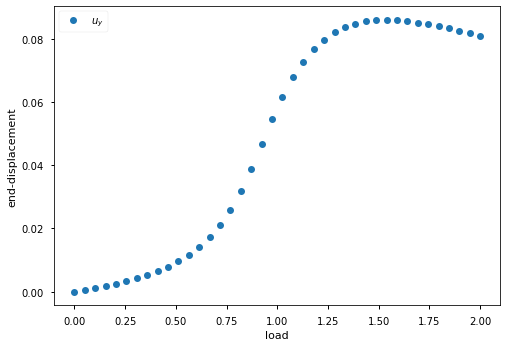

In [51]:
loads, displ = hypsol.solve(params)
plt.plot(loads, displ, "o", label=(r'$u_y$'))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()

None


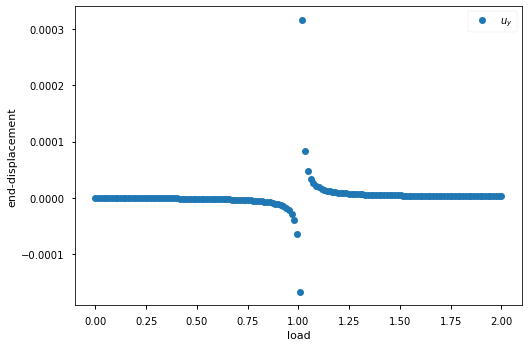

In [42]:
params['alpha'] = 0
params['alpha_right'] = 0
params['nsteps'] = 150

params['max_loads'] = 1.2
loads, displ = hypsol.solve(params)
plt.plot(loads, displ, "o", label=(r'$u_y$'))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()

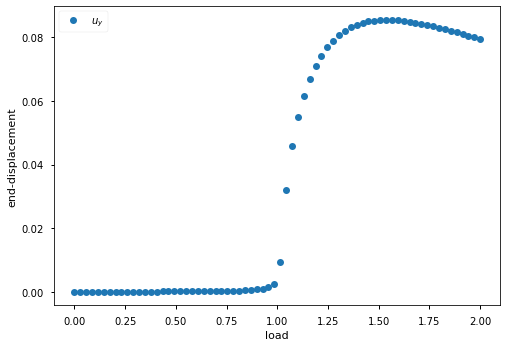

In [123]:
params['alpha'] = 0.001
params['alpha_right'] = 0.001
params['nsteps'] = 70

loads, displ = hypsol.solve(params)
plt.plot(loads, displ, "o", label=(r'$u_y$'))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()

#### Question 2.2

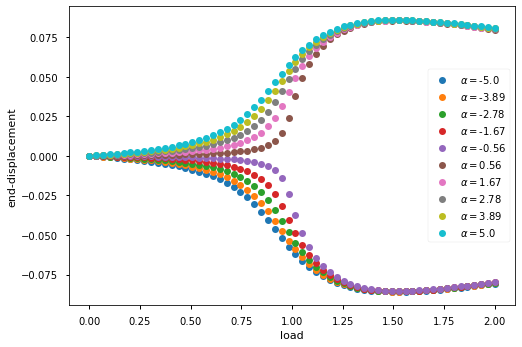

In [39]:
params['nsteps'] = 60
alphas = np.linspace(-5*np.pi/180, 5*np.pi/180, 10)
for alpha in alphas:
    params['alpha'] = alpha
    loads, displ = hypsol.solve(params)
    plt.plot(loads, displ, "o", label=(r'$\alpha = $'+str(round(alpha*180/np.pi,2))))
    plt.xlabel("load")
    plt.ylabel("end-displacement")
    plt.legend()

#### Question 2.3

### Part 3. (Nonlinear) Bridge design

In [56]:
def findLengthForStrengthLimites(ks, hypsol, Ly, Y, adim_params, load_max=1, nsteps=60):
    max_sigma_xx = np.zeros_like(ks)
    min_sigma_xx = np.zeros_like(ks)
    max_loads = np.zeros_like(ks)
    all_fe_sigma_xx = []
    all_fe_sigma_yy = []

    plt.figure(1)
    for i, k in enumerate(ks):
        Lx = k * Ly
        adim_params['Ly'] = Ly/Lx 
        adim_params['rho_g'] = rho*g*Lx/Y
        adim_params['load_max'] = load_max
        adim_params['nsteps'] = nsteps
        
        loads, displ = hypsol.solve(adim_params)

        stress_field_space = dolfin.FunctionSpace(hypsol.mesh, 'DG', 1)
        # hypsol.strain_displacement()
        sigma, _, _ = hypsol.stresses_nonlinear()
        fe_sigma_xx = dolfin.project(sigma[0,0], stress_field_space)
        fe_sigma_yy = dolfin.project(sigma[1,1], stress_field_space)

        all_fe_sigma_xx.append(fe_sigma_xx)
        all_fe_sigma_yy.append(fe_sigma_yy)

        min_sigma_xx[i] = np.min(fe_sigma_xx.compute_vertex_values())
        max_sigma_xx[i] = np.max(fe_sigma_xx.compute_vertex_values())

        max_loads[i] = loads[np.argmax(displ)]

        plt.plot(loads, displ, "o", label=(r'$L_x = $' + str(round(Lx,2))) + 'm')
        plt.xlabel("load")
        plt.ylabel("end-displacement")
        plt.legend()
    return min_sigma_xx, max_sigma_xx, max_loads, all_fe_sigma_xx, all_fe_sigma_yy

def plotCompressionResistance(ks, min_sigma_xx):
    sigma_C_ref = np.full(ks.shape, fc/Y)
    plt.plot(ks, sigma_C_ref, label=r'$\hat{fc}$')
    plt.plot(ks, np.abs(min_sigma_xx), "o", label=('|min sxx|'))
    plt.xlabel(r'$L_x/L_y$')
    plt.ylabel(r'$\hat{\sigma_{xx}}$')
    plt.title('Stress component ')
    plt.grid()
    plt.legend()

def plotTensionResistance(ks, max_sigma_xx):
    plt.plot(ks, max_sigma_xx, "o-", label=('max sxx'))
    plt.xlabel(r'$L_x/L_y$')
    plt.ylabel(r'$\hat{\sigma_{xx}}$')
    plt.title('Stress component ')
    plt.grid()
    plt.legend()

In [34]:
Y = 37e9 #[Pa]
Ly = 10 #[m]
g = 9.8 #[m/s^2]
rho = 2500 #[kg/m^3]

nu = 0.35 #[-]
fc = 46e6 #[Pa]
alpha = 0.0045
Gamma = 7.8
Lx = 300
params = {'Lx':1, 'Ly':Ly/Lx, 'alpha':alpha, 'rho_g':rho*g*Lx/Y, 'load_max':1, 'nsteps':60, 'load_min':0, 'nx':20, 'ny':5, 'alpha_right':alpha, 'load_middle':1}

#Gamma Compression Tension
#Ly=10
#Ly=20
#Ly=35
Lx_limits = np.zeros((3, 3)) 
max_sigma_xx_cases = []

hypsol = HyperelasticitySolver((Y/Y), nu)

print('Theoretical Lx =', pow(Gamma * Y * Ly**2 / (rho * g), 1./3.))

Y = 1.0 nu = 0.35
Theoretical Lx = 1056.1122517055744


In [8]:
print('sigma_T =', round(0.1*fc/Y, 5))

sigma_T = 0.00012


#### For testing

In [22]:
max_sigma_xx, max_sigma_yy, max_loads = findLengthForStrengthLimites(np.array([60]), hypsol, Ly, Y, params, load_max=1, nsteps=120)

ValueError: Number of samples, -23, must be non-negative.

<Figure size 576x396 with 0 Axes>

In [11]:
stress_field_space = dolfin.FunctionSpace(hypsol.mesh, 'DG', 1)
hypsol.strain_displacement()
sigma = hypsol.stress_strain()
fe_sigma_xx = dolfin.project(sigma[0,0], stress_field_space)
fe_sigma_yy = dolfin.project(sigma[1,1], stress_field_space)

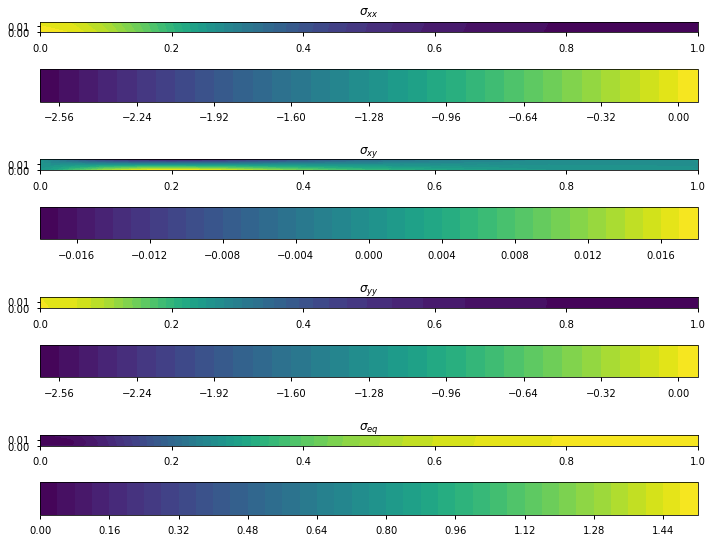

In [20]:
s = sigma - (1./3)*dolfin.tr(sigma)*dolfin.Identity(2)  # deviatoric stress
von_Mises = dolfin.sqrt(3./2*dolfin.inner(s, s))
von_Mises = dolfin.project(von_Mises, stress_field_space)

plt.figure(figsize=[10, 8])

plt.subplot(4, 1, 1)
plt.colorbar(dolfin.plot(hypsol.sigma[0,0]), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{xx}$')

plt.subplot(4, 1, 2)
plt.colorbar(dolfin.plot(hypsol.sigma[0,1]), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{xy}$')

plt.subplot(4, 1, 3)
plt.colorbar(dolfin.plot(hypsol.sigma[1,1]), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{yy}$')

plt.subplot(4, 1, 4)
plt.colorbar(dolfin.plot(von_Mises), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{eq}$')

plt.tight_layout()

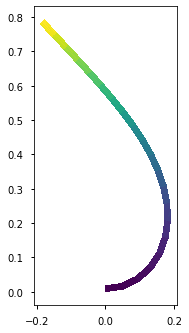

In [21]:
dolfin.plot(hypsol.u, mode='displacement')

#### Question 3.1

In [26]:
ks = np.linspace(53.5, 54, 7)
_, _, max_loads = findLengthForStrengthLimites(ks, hypsol, Ly, Y, params, load_max=1.2, nsteps=120)

KeyboardInterrupt: 

<Figure size 576x396 with 0 Axes>

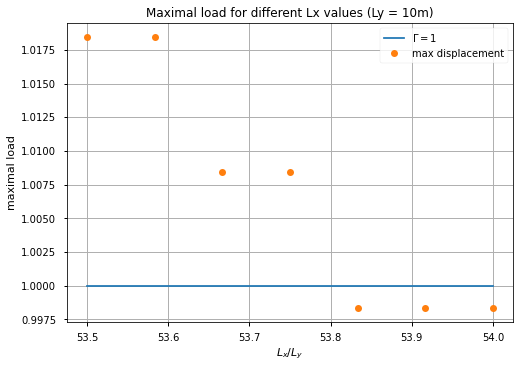

In [31]:
ref_load = np.full(max_loads.shape, 1)
plt.plot(ks, ref_load, label=r'$\Gamma = 1$')
plt.plot(ks, max_loads, "o", label='max displacement')
plt.xlabel(r'$L_x/L_y$')
plt.ylabel("maximal load")
plt.title('Maximal load for different Lx values (Ly = 10m)')
plt.grid()
plt.legend()

$k = \frac{L_x}{L_y} \approx 53.75$

In [140]:
Ly = 10
Lx_limits[0][0] = Ly*53.75
print('Lx = ', Lx_limits[0][0])

Lx =  537.5


500.0
508.33333333333337
516.6666666666666
525.0
533.3333333333334
541.6666666666666
550.0


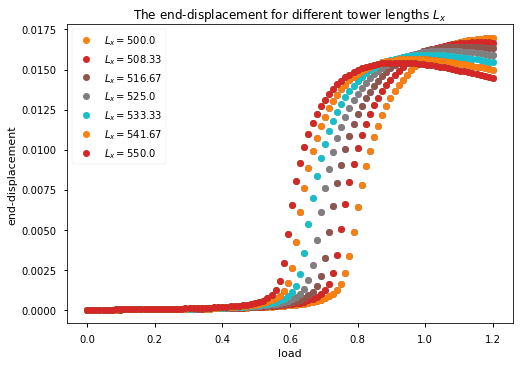

In [28]:
# ks = np.linspace(50, 55, 7)
# max_loads = ks * 0.
# for i, k in enumerate(ks):
#     Lx = k * Ly
#     params = {'Lx':1, 'Y':Y/Y, 'nu':nu, 'Ly':Ly/Lx, 'alpha':alpha, 'Gamma':Gamma, 'rho_g':rho*g*Lx/Y }

#     _, loads, displ = solve_hyperelasticity(load_max=1.2, nsteps=100, load_min=0, nx=30, ny=20, params=params)
#     max_loads[i] = loads[np.argmax(displ)]
#     plt.plot(loads, displ, "o", label=(r'$L_x = $' + str(round(Lx,2))))
#     plt.xlabel("load")
#     plt.ylabel("end-displacement")
#     plt.legend()
#     plt.title('The end-displacement for different tower lengths ' + r'$L_x$')


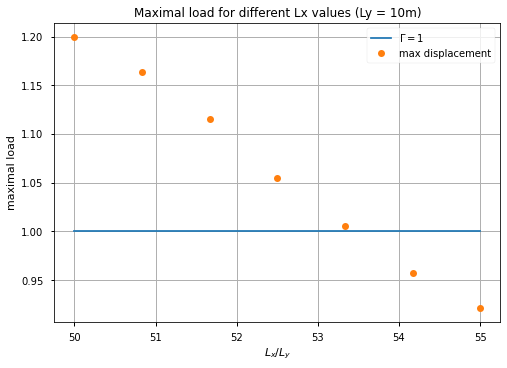

In [29]:
# ref_load = np.full(max_loads.shape, 1)
# plt.plot(ks, ref_load, label=r'$\Gamma = 1$')
# plt.plot(ks, max_loads, "o", label='max displacement')
# plt.xlabel(r'$L_x/L_y$')
# plt.ylabel("maximal load")
# plt.title('Maximal load for different Lx values (Ly = 10m)')
# plt.grid()
# plt.legend()

#### Question 3.2

1 0.9
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
1 0.9
1 0.9
1 0.9
1 0.9
1 0.9


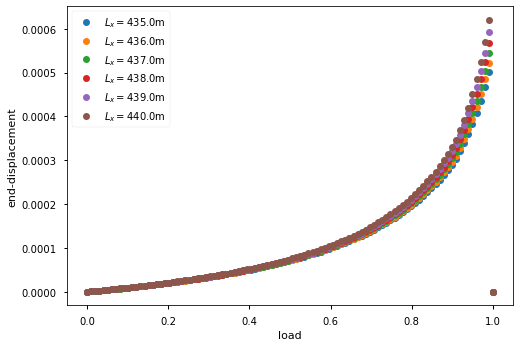

In [29]:
ks = np.linspace(43.5, 44, 6)
min_sigma_xx, _, _, all_fe_sigma_xx, all_fe_sigma_yy = findLengthForStrengthLimites(ks, hypsol, Ly, Y, params, load_max=1, nsteps=100)

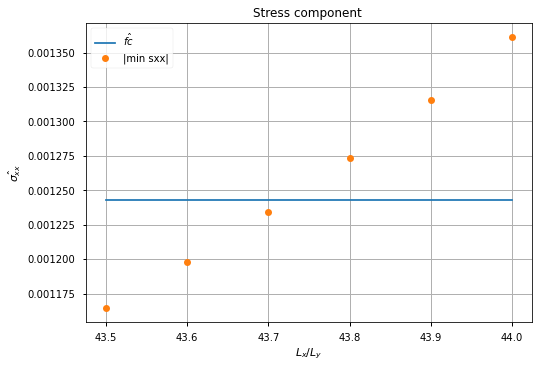

In [31]:
sigma_C_ref = np.full(ks.shape, fc/Y)
plt.plot(ks, sigma_C_ref, label=r'$\hat{fc}$')
plt.plot(ks, abs(min_sigma_xx), "o", label=('|min sxx|'))
plt.xlabel(r'$L_x/L_y$')
plt.ylabel(r'$\hat{\sigma_{xx}}$')
plt.title('Stress component ')
plt.grid()
plt.legend()


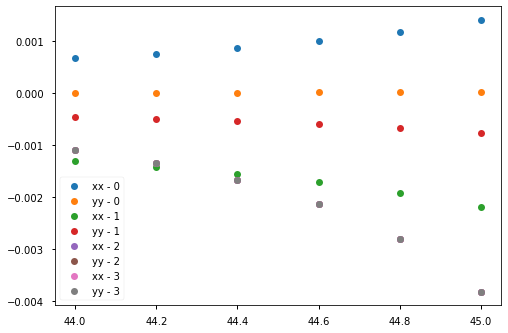

In [39]:
sigma_xx_values = np.zeros((4, len(ks)))
sigma_yy_values = np.zeros((4, len(ks)))

coord_x = [0, 0, params['Lx'], params['Lx']]
coord_y = [0, params['Ly'], 0, params['Ly']]
for i in range(4):
    for j, sigma_xx in enumerate(all_fe_sigma_xx):
        sigma_xx_values[i][j] = sigma_xx(coord_x[i], coord_y[i])
        sigma_yy_values[i][j] = all_fe_sigma_yy[j](coord_x[i], coord_y[i])
    plt.plot(ks, sigma_xx_values[i,:], 'o', label='xx - ' + str(i))
    plt.plot(ks, sigma_yy_values[i,:], 'o', label='yy - ' + str(i))
plt.legend()

$k = \frac{L_x}{L_y} \approx 43.7$

In [36]:
Ly = 10
Lx_limits[0][1] = Ly*43.7
print('Lx = ', Lx_limits[0][1])

Lx =  437.0


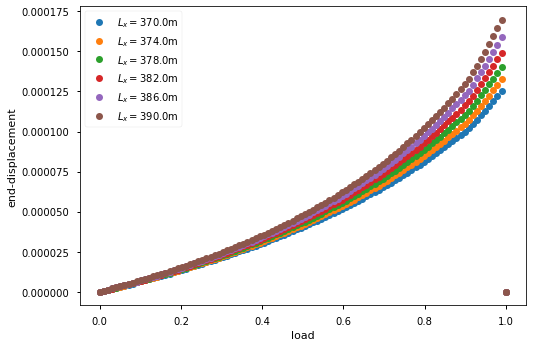

In [35]:
ks = np.linspace(37, 39, 6)
min_sigma_xx, max_sigma_xx, _, _, _ = findLengthForStrengthLimites(ks, hypsol, Ly, Y, params, load_max=1, nsteps=100)

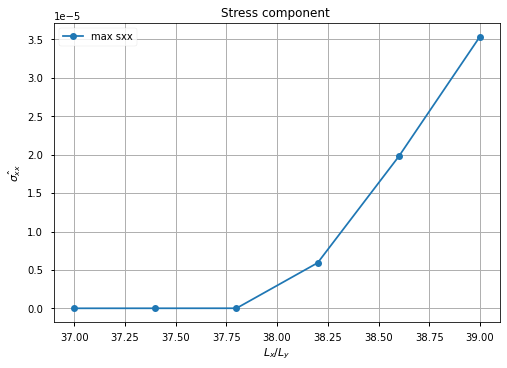

In [37]:
plt.plot(ks, max_sigma_xx, "o-", label=('max sxx'))
plt.xlabel(r'$L_x/L_y$')
plt.ylabel(r'$\hat{\sigma_{xx}}$')
plt.title('Stress component ')
plt.grid()
plt.legend()

$\sigma_{xx} = \sigma_T \approx 0$


In [38]:
Ly = 10
Lx_limits[0][2] = Ly*38
print('Lx = ', Lx_limits[0][2])

Lx =  380.0


#### Question 3.3

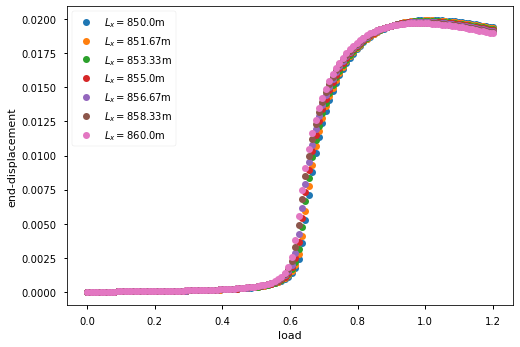

In [13]:
ks = np.linspace(42.5, 43, 7)
_, _, max_loads, _, _ = findLengthForStrengthLimites(ks, hypsol, Ly=20, Y=Y, adim_params=params, load_max=1.2, nsteps=120)

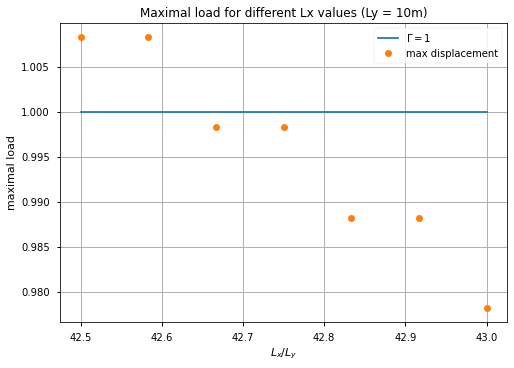

In [14]:
ref_load = np.full(max_loads.shape, 1)
plt.plot(ks, ref_load, label=r'$\Gamma = 1$')
plt.plot(ks, max_loads, "o", label='max displacement')
plt.xlabel(r'$L_x/L_y$')
plt.ylabel("maximal load")
plt.title('Maximal load for different Lx values (Ly = 20m)')
plt.grid()
plt.legend()

In [145]:
Ly = 20
Lx_limits[1][0] = Ly*42.65
print('Lx = ', Lx_limits[1][0])

Lx =  853.0


#### Question 3.4

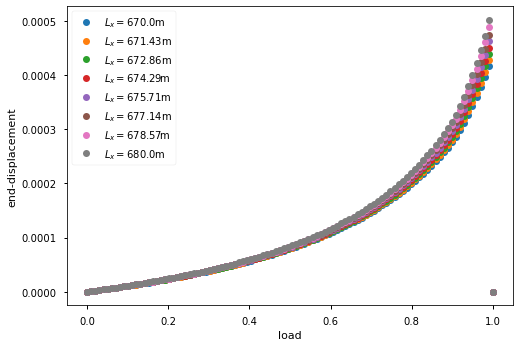

In [39]:
ks = np.linspace(33.5, 34, 8)
min_sigma_xx, _, _, _, _ = findLengthForStrengthLimites(ks, hypsol, Ly=20, Y=Y, adim_params=params, nsteps=100)

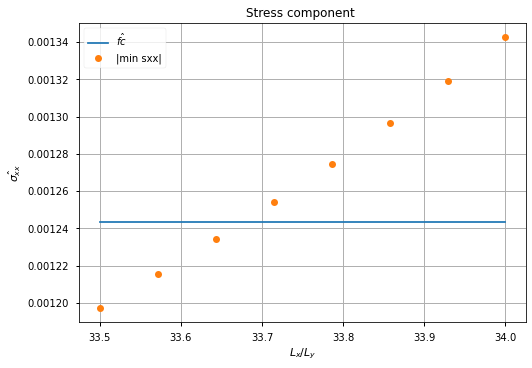

In [40]:
plotCompressionResistance(ks, min_sigma_xx)

In [41]:
Ly = 20
Lx_limits[1][1] = Ly*33.65
print('Lx = ', Lx_limits[1][1])

Lx =  673.0


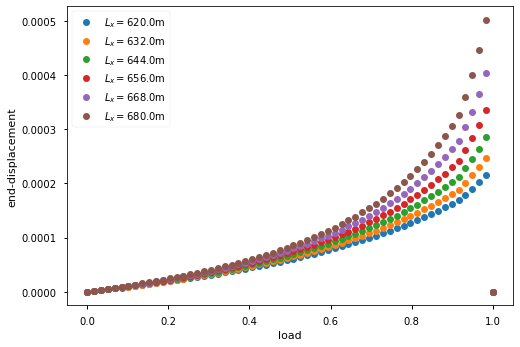

In [43]:
ks = np.linspace(31, 34, 6)
_, max_sigma_xx, _, _, _ = findLengthForStrengthLimites(ks, hypsol, Ly=20, Y=Y, adim_params=params, load_max=1, nsteps=60)

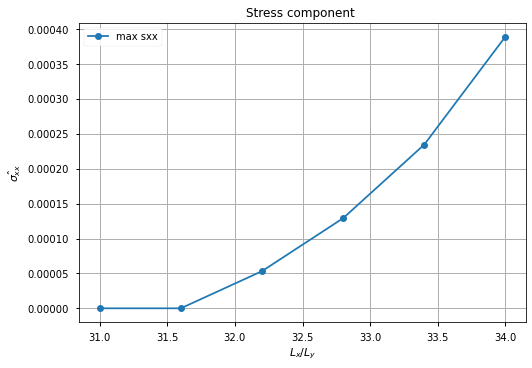

In [44]:
plotTensionResistance(ks, max_sigma_xx)

In [45]:
Ly = 20
Lx_limits[1][2] = Ly*31.5
print('Lx = ', Lx_limits[1][2])

Lx =  630.0


#### Question 3.5

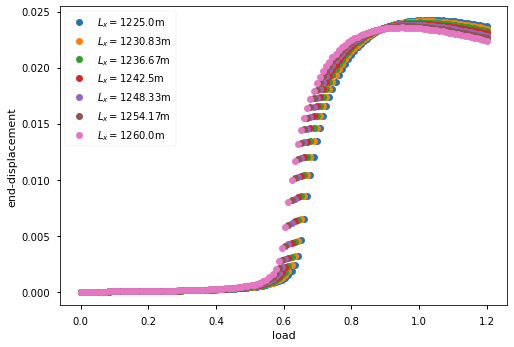

In [152]:
ks = np.linspace(35, 36, 7)
_, _, max_loads, _, _ = findLengthForStrengthLimites(ks, hypsol, Ly=35, Y=Y, adim_params=params, load_max=1.2, nsteps=130)

In [46]:
ref_load = np.full(max_loads.shape, 1)
plt.plot(ks, ref_load, label=r'$\Gamma = 1$')
plt.plot(ks, max_loads, "o", label='max displacement')
plt.xlabel(r'$L_x/L_y$')
plt.ylabel("maximal load")
plt.title('Maximal load for different Lx values (Ly = 10m)')
plt.grid()
plt.legend()

NameError: name 'max_loads' is not defined

In [47]:
Ly = 35
Lx_limits[2][0] = Ly*35.3
print('Lx = ', Lx_limits[2][0])

Lx =  1235.5


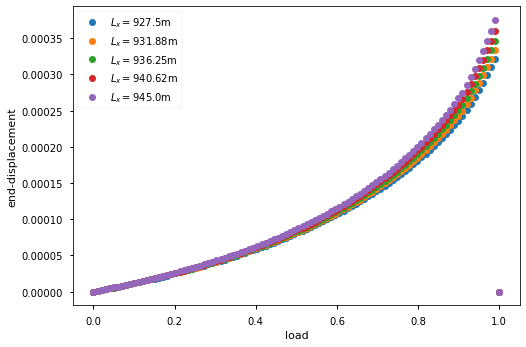

In [48]:
ks = np.linspace(26.5, 27, 5)
max_sigma_xx, _, _, _, _ = findLengthForStrengthLimites(ks, hypsol, Ly=35, Y=Y, adim_params=params, nsteps=100)

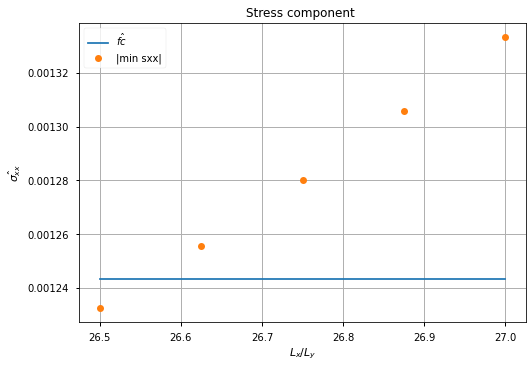

In [50]:
plotCompressionResistance(ks, max_sigma_xx)

In [51]:
Ly = 35
Lx_limits[2][1] = Ly*26.6
print('Lx = ', Lx_limits[2][1])

Lx =  931.0


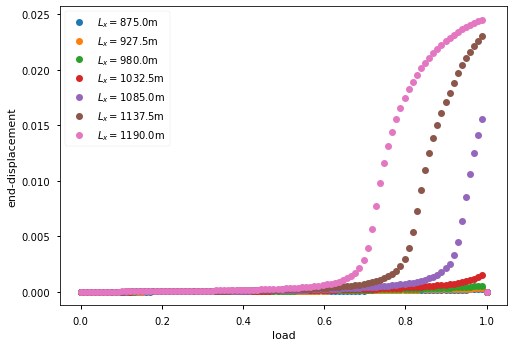

In [57]:
ks = np.linspace(25, 34, 7)
_, min_sigma_xx, _, _, _ = findLengthForStrengthLimites(ks, hypsol, Ly=35, Y=Y, adim_params=params, load_max=1, nsteps=100)

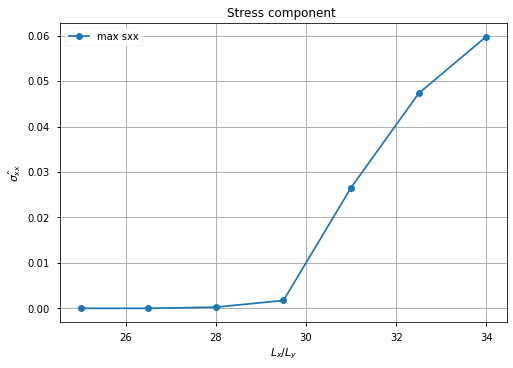

In [58]:
plotTensionResistance(ks, min_sigma_xx)

In [59]:
Ly = 35
Lx_limits[2][2] = Ly*ks[3]
print('Lx = ', Lx_limits[2][2])

Lx =  1032.5


In [55]:
Lx_limits

array([[   0. ,  437. ,  380. ],
       [   0. ,  673. ,  630. ],
       [1235.5,  931. , 1032.5]])

#### Question 3.6

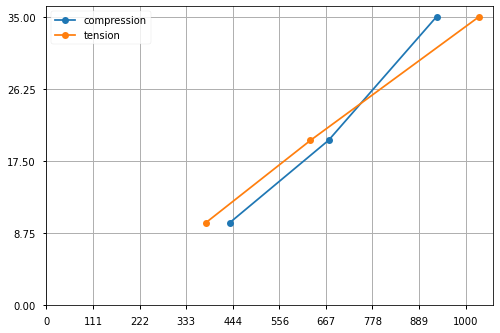

In [101]:
Ly_limits = [10, 20, 35]

# plt.plot(Lx_limits[:,0], Ly_limits, 'o-', label='reach Gamma')
plt.plot(Lx_limits[:,1], Ly_limits, 'o-', label='compression')
plt.plot(Lx_limits[:,2], Ly_limits, 'o-', label='tension')
# for i, Ly in enumerate(Ly_limits):
#     plt.plot(Lx_limits[i], [Ly, Ly, Ly], 'o')
plt.legend()
plt.xticks(np.linspace(0, 1000, 10))
plt.yticks(np.linspace(0, 35, 5))
# plt.axis('off')
plt.grid()

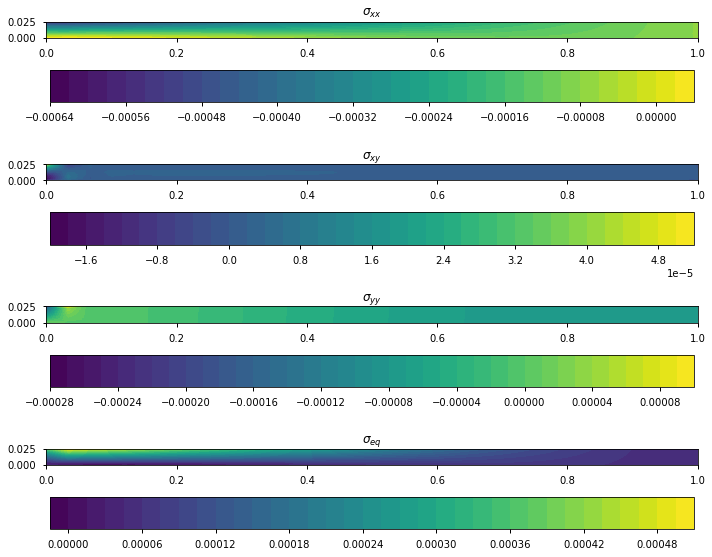

In [ ]:
stress_field_space = dolfin.FunctionSpace(hypsol.mesh, 'DG', 1)
hypsol.strain_displacement()
sigma = hypsol.stress_strain()
s = sigma - (1./3)*dolfin.tr(sigma)*dolfin.Identity(2)  # deviatoric stress
von_Mises = dolfin.sqrt(3./2*dolfin.inner(s, s))
von_Mises = dolfin.project(von_Mises, stress_field_space)

plt.figure(figsize=[10, 8])

plt.subplot(4, 1, 1)
plt.colorbar(dolfin.plot(hypsol.sigma[0,0]), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{xx}$')

plt.subplot(4, 1, 2)
plt.colorbar(dolfin.plot(hypsol.sigma[0,1]), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{xy}$')

plt.subplot(4, 1, 3)
plt.colorbar(dolfin.plot(hypsol.sigma[1,1]), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{yy}$')

plt.subplot(4, 1, 4)
plt.colorbar(dolfin.plot(von_Mises), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{eq}$')

plt.tight_layout()

### Part 10

#### Question 10.1

In [6]:
Lx = 1 #[m]
Y = 1100 #[Pa]
nu = 0.35 #[-]
Ly = 0.1
alpha = 0
Gamma = 7.84
rho_g = Gamma * Y * Ly**2 / 12 / Lx**3

params = {'Lx':Lx, 'Ly':Ly, 'alpha':alpha, 'Gamma':Gamma, 'rho_g':rho_g, 'load_max':2, 'nsteps':40, 'load_min':0, 'nx':20, 'ny':5, 'alpha_right':alpha, 'load_middle':1.2}
hypsol = HyperelasticitySolver(Y, nu)

Y = 1100 nu = 0.35


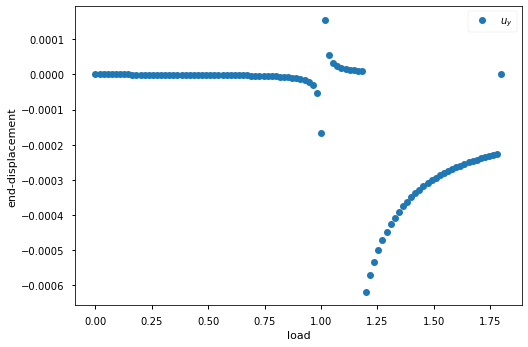

In [8]:
params['alpha'] = 0
params['alpha_right'] = 0.001
params['load_max'] = 1.8
params['nsteps'] = 100
params['Ly'] = 0.1
loads, displ = hypsol.solve(params)
plt.plot(loads, displ, "o", label=(r'$u_y$'))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()

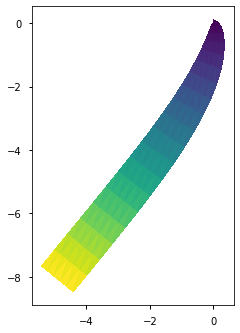

In [27]:
dolfin.plot(hypsol.u*10, mode='displacement')


#### Question 10.2

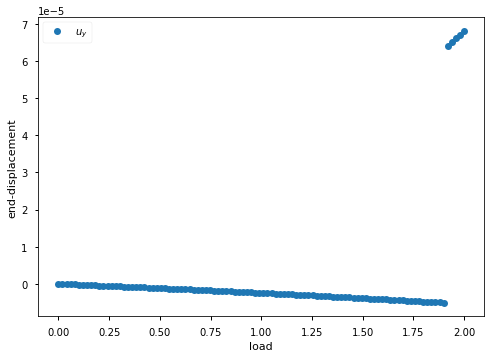

In [14]:
params['alpha'] = 0
params['alpha_right'] = 0.001
params['load_max'] = 2
params['nsteps'] = 100
params['Ly'] = 0.35
loads, displ = hypsol.solve(params)

plt.plot(loads, displ, "o", label=(r'$u_y$'))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()

#### Question 10.3

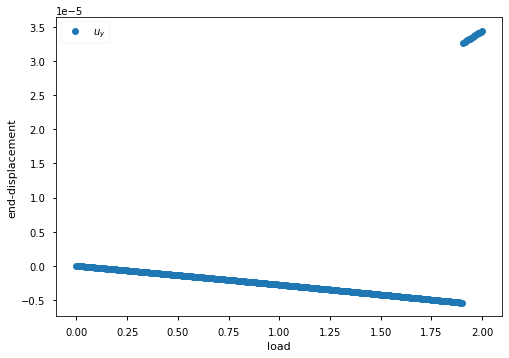

In [12]:
params['alpha'] = 0
params['alpha_right'] = 0.001
params['load_max'] = 2
params['nsteps'] = 300
params['Ly'] = 0.95
loads, displ = hypsol.solve(params)

plt.plot(loads, displ, "o", label=(r'$u_y$'))
plt.xlabel("load")1.5
plt.ylabel("end-displacement")
plt.legend()

### Part 20

In [61]:
Lx = 1 #[m]
Y = 1100 #[Pa]
nu = 0.35 #[-]
Ly = 0.1*Lx
alpha = 0
Gamma = 7.84
rho_g = Gamma * Y * Ly**2 / 12 / Lx**3

params = {'Lx':Lx, 'Ly':Ly, 'alpha':alpha, 'Gamma':Gamma, 'rho_g':rho_g, 'load_max':2, 'nsteps':40, 'load_min':0, 'nx':20, 'ny':5, 'alpha_right':alpha, 'load_middle':1.2}
hypsol = HyperelasticitySolver(Y, nu)

Y = 1100 nu = 0.35


No handles with labels found to put in legend.


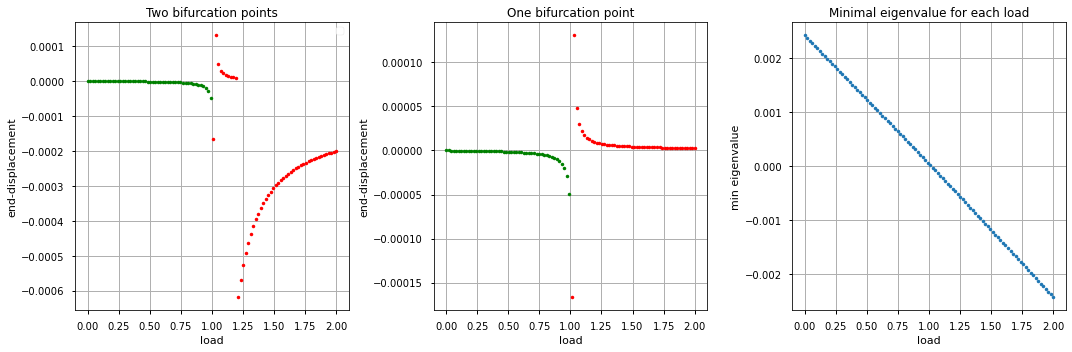

In [10]:
params['alpha'] = 0
params['alpha_right'] = 0.001
params['load_max'] = 2
params['nsteps'] = 100
loads, displ = hypsol.solve(params)

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.plot(loads[loads<1], displ[loads<1], ".g")
plt.plot(loads[loads>1], displ[loads>1], ".r")
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()
plt.grid()
plt.title('Two bifurcation points')

params['alpha_right'] = 0.0
params['nsteps'] = 100
loads, displ = hypsol.solve(params)

plt.subplot(1, 3, 2)
plt.plot(loads[loads<1], displ[loads<1], ".g", label=(r'$u_y$'))
plt.plot(loads[loads>1], displ[loads>1], ".r", label=(r'$u_y$'))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.grid()
plt.title('One bifurcation point')

plt.subplot(1, 3, 3)
plt.plot(loads, hypsol.min_eig, ".")
plt.xlabel("load")
plt.ylabel("min eigenvalue")
plt.grid()
plt.title('Minimal eigenvalue for each load')

plt.tight_layout()

plt.savefig('img/part20_bif_points.png', dpi=300)

No handles with labels found to put in legend.


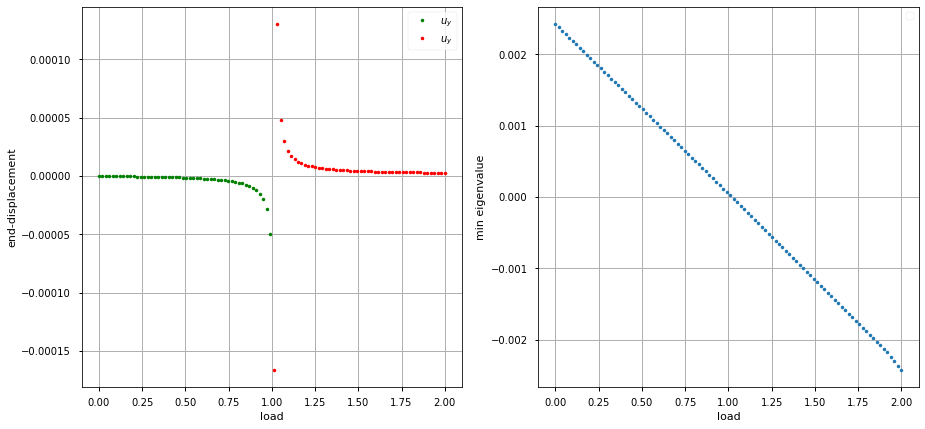

In [15]:
params['alpha'] = 0
params['alpha_right'] = 0.0
params['load_max'] = 2
params['nsteps'] = 100
loads, displ = hypsol.solve(params)

plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
plt.plot(loads[loads<1], displ[loads<1], ".g", label=(r'$u_y$'))
plt.plot(loads[loads>1], displ[loads>1], ".r", label=(r'$u_y$'))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()
plt.grid()
plt.title('One bifurcation point')

plt.subplot(1, 2, 2)
plt.plot(loads, hypsol.min_eig, ".")
plt.xlabel("load")
plt.ylabel("min eigenvalue")
plt.legend()
plt.grid()
plt.title('Minimal eigenvalue for each load')

plt.savefig('img/part20_1_bif_points.png', dpi=300)


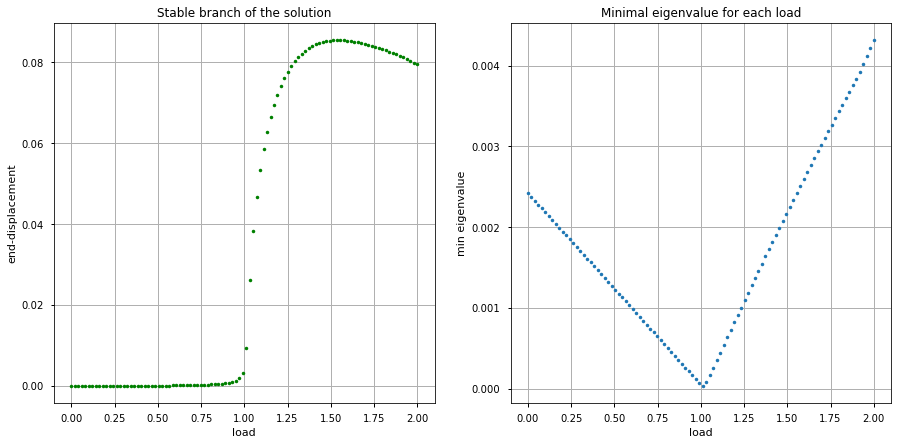

In [22]:
params['alpha'] = 0.001
params['alpha_right'] = 0.001
params['load_max'] = 2
params['nsteps'] = 100
loads, displ = hypsol.solve(params)

plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
plt.plot(loads, displ, ".g", label=(r'$u_y$'))
plt.xlabel("load")
plt.ylabel("end-displacement")
# plt.legend()
plt.grid()
plt.title('Stable branch of the solution')

plt.subplot(1, 2, 2)
plt.plot(loads, hypsol.min_eig, ".")
plt.xlabel("load")
plt.ylabel("min eigenvalue")
# plt.legend()
plt.grid()
plt.title('Minimal eigenvalue for each load')

plt.savefig('img/part20_no_bif_points.png', dpi=300)

### Testing

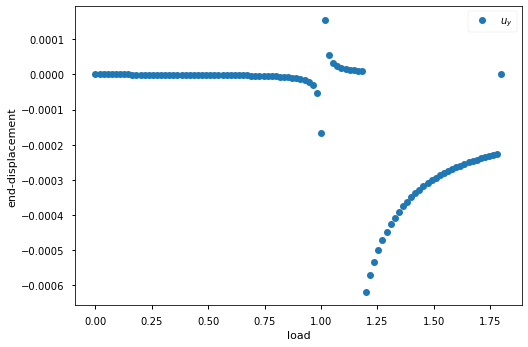

In [11]:
params['alpha'] = 0
params['alpha_right'] = 0.001
params['load_max'] = 1.8
params['nsteps'] = 100
params['Ly'] = 0.1
loads, displ = hypsol.solve(params)
plt.plot(loads, displ, "o", label=(r'$u_y$'))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()

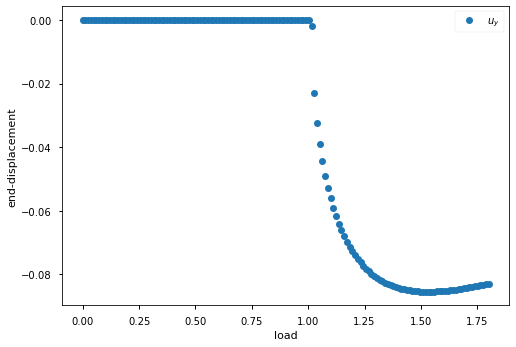

In [12]:
params['alpha'] = 0
params['alpha_right'] = 0.001
params['load_max'] = 1.8
params['nsteps'] = 150
params['Ly'] = 0.1
loads, displ = hypsol.solve(params)
plt.plot(loads, displ, "o", label=(r'$u_y$'))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()

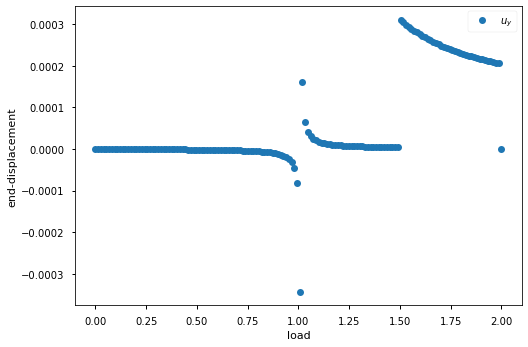

In [14]:
params['alpha'] = 0
params['alpha_right'] = -0.001
params['load_max'] = 2
params['load_middle'] = 1.5
params['nsteps'] = 150
params['Ly'] = 0.1
loads, displ = hypsol.solve(params)
plt.plot(loads, displ, "o", label=(r'$u_y$'))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()

In [62]:
params['alpha'] = 0.01
params['alpha_right'] = -0.1
params['load_max'] = 2
params['load_middle'] = 1.1
params['nsteps'] = 500
params['Ly'] = 0.1
loads, displ = hypsol.solve(params)
plt.plot(loads, displ, "o", label=(r'$u_y$'))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()

KeyboardInterrupt: 

In [ ]:
hypsol.solve(params)

# Stressess

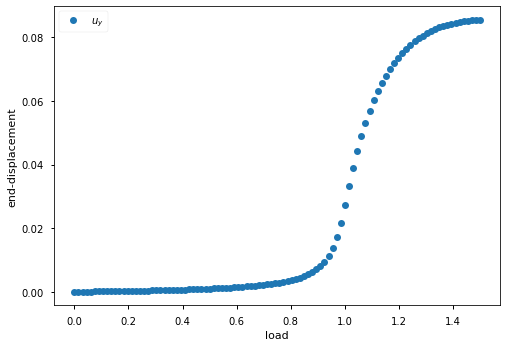

In [13]:
params['alpha'] = 0.01
params['alpha_right'] = 0.01
params['load_max'] = 1.5
params['nsteps'] = 100
params['Ly'] = 0.1
loads, displ = hypsol.solve(params)
plt.plot(loads, displ, "o", label=(r'$u_y$'))
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()

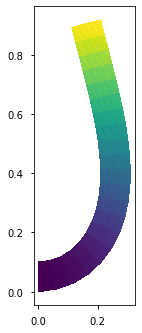

In [14]:
dolfin.plot(hypsol.u, mode='displacement')

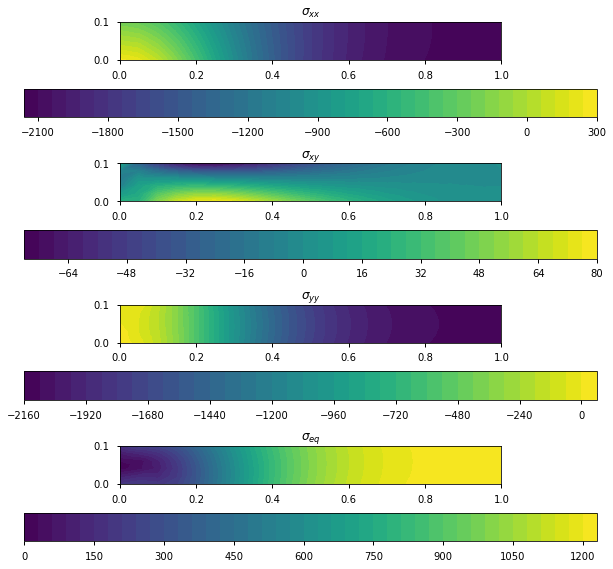

In [16]:
stress_field_space = dolfin.FunctionSpace(hypsol.mesh, 'DG', 1)
hypsol.strain_displacement()
sigma = hypsol.stress_strain()
sigma_nonlin, P, S = hypsol.stresses_nonlinear()

s = sigma - (1./3)*dolfin.tr(sigma)*dolfin.Identity(2)  # deviatoric stress
von_Mises = dolfin.sqrt(3./2*dolfin.inner(s, s))
von_Mises = dolfin.project(von_Mises, stress_field_space)

plt.clim(-5, 9)

plt.figure(figsize=[10, 8])
plt.subplot(4, 1, 1)
plt.colorbar(dolfin.plot(hypsol.sigma[0,0]), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{xx}$')

plt.subplot(4, 1, 2)
plt.colorbar(dolfin.plot(hypsol.sigma[0,1]), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{xy}$')

plt.subplot(4, 1, 3)
plt.colorbar(dolfin.plot(hypsol.sigma[1,1]), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{yy}$')

plt.subplot(4, 1, 4)
plt.colorbar(dolfin.plot(von_Mises), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{eq}$')

plt.tight_layout()

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


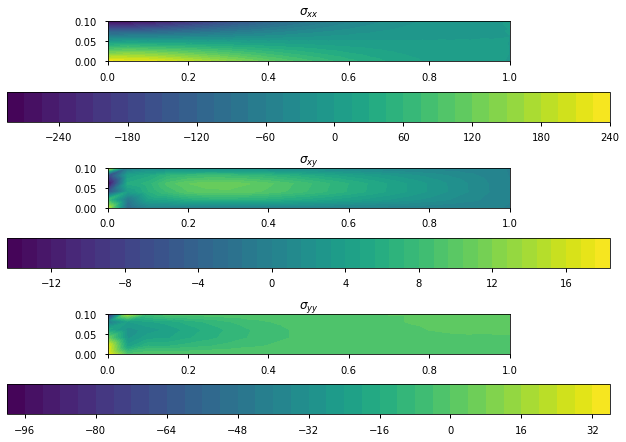

In [17]:
plt.figure(figsize=[10, 8])
plt.subplot(4, 1, 1)
plt.colorbar(dolfin.plot(sigma_nonlin[0,0]), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{xx}$')

plt.subplot(4, 1, 2)
plt.colorbar(dolfin.plot(sigma_nonlin[0,1]), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{xy}$')

plt.subplot(4, 1, 3)
plt.colorbar(dolfin.plot(sigma_nonlin[1,1]), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{yy}$')

plt.tight_layout()

## Piolla-Kirschoff 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


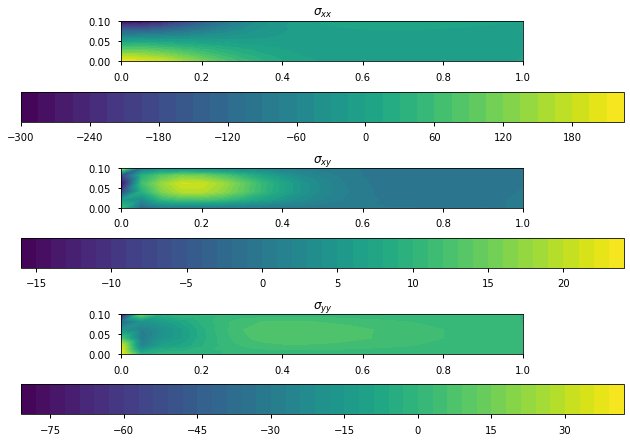

In [18]:
plt.figure(figsize=[10, 8])
plt.subplot(4, 1, 1)
plt.colorbar(dolfin.plot(P[0,0]), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{xx}$')

plt.subplot(4, 1, 2)
plt.colorbar(dolfin.plot(P[0,1]), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{xy}$')

plt.subplot(4, 1, 3)
plt.colorbar(dolfin.plot(P[1,1]), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{yy}$')

plt.tight_layout()

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


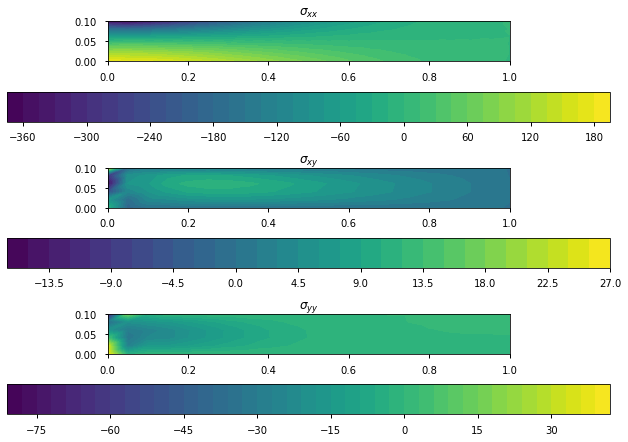

In [19]:
plt.figure(figsize=[10, 8])
plt.subplot(4, 1, 1)
plt.colorbar(dolfin.plot(S[0,0]), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{xx}$')

plt.subplot(4, 1, 2)
plt.colorbar(dolfin.plot(S[0,1]), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{xy}$')

plt.subplot(4, 1, 3)
plt.colorbar(dolfin.plot(S[1,1]), location='bottom', fraction=0.3, pad=0.3)
plt.title(r'$\sigma_{yy}$')

plt.tight_layout()